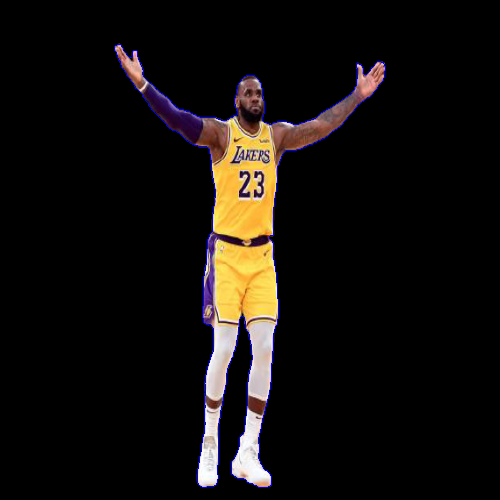

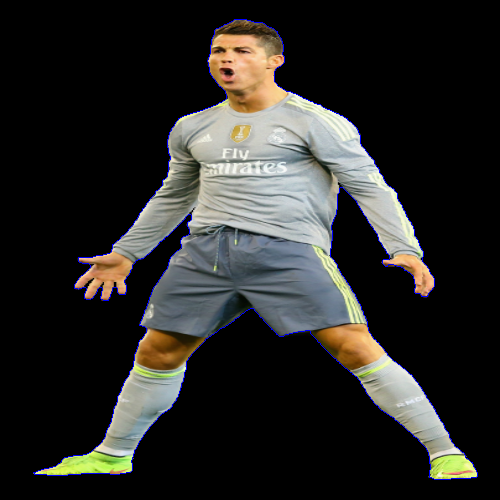

In [1]:
import numpy as np
import cv2
from PIL import Image 
from google.colab.patches import cv2_imshow

# Parameters
blur = 21
canny_low = 30
canny_high = 200
inWidth = 500
inHeight = 500

inputImageName = "./drive/MyDrive/PoseProject/lbj.png"
refImageName = "./drive/MyDrive/PoseProject/cr.png"
#refImageName = "jo4.png"

def getContourPoints(imageName):
  inputImage = cv2.imread(imageName)
  inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))
  # Convert image to grayscale        
  image_gray = cv2.cvtColor(inputImageResize, cv2.COLOR_BGR2GRAY)
  # Apply Canny Edge Dection
  edges = cv2.Canny(image_gray, canny_low, canny_high)
  edges = cv2.dilate(edges, None)
  edges = cv2.erode(edges, None)
  # get the contours and their areas
  inputContours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  inputMaxContour = inputContours[0]
  for contour in inputContours:
    if cv2.contourArea(contour) > cv2.contourArea(inputMaxContour):
      inputMaxContour = contour

  inputContourPoints = inputMaxContour[:, 0, :]
  for point in inputContourPoints:
    inputImageResize[point[1], point[0], 0] = 255
    inputImageResize[point[1], point[0], 1] = 0
    inputImageResize[point[1], point[0], 2] = 0

  cv2_imshow(inputImageResize) 

  return inputContourPoints

inputContourPoints = getContourPoints(inputImageName)
refContourPoints = getContourPoints(refImageName)

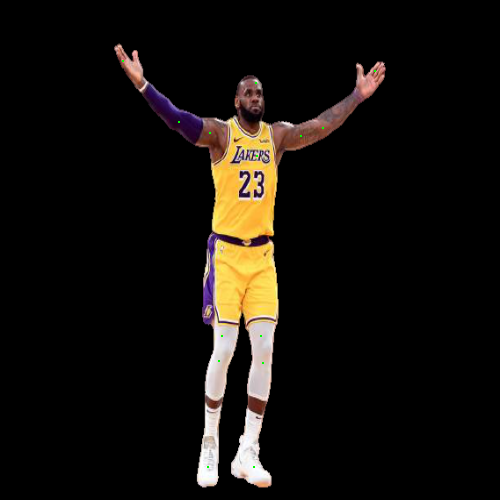

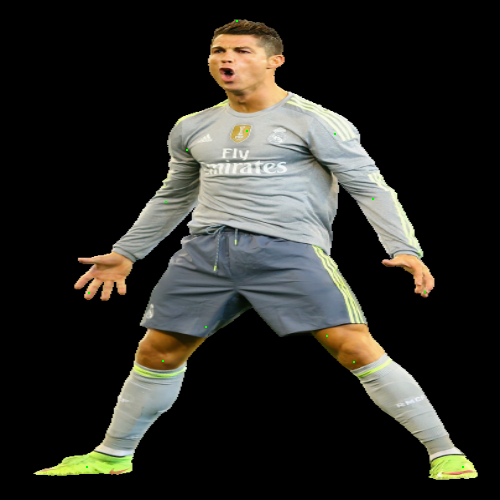

In [30]:
import math

# #0: head
# #1: chest
# #2: left shoulder
# #3: left elbow
# #4: left hand
# #5: right shoulder
# #6: right elbow
# #7: right hand
# #8: left waist
# #9: left knee
# #10: left foot
# #11: right waist
# #12: right knee
# #13: right foot
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]

pointsLBJNormal = [
  (0.510,	0.164),
  (0.512,	0.311),
  (0.419,	0.264),
  (0.356,	0.242),
  (0.245,	0.12),
  (0.60,	0.271),
  (0.644,	0.254),
  (0.749,	0.14),
  (0.442,	0.67),
  (0.436,	0.721),
  (0.415,	0.933),
  (0.520,	0.67),
  (0.525,	0.724),
  (0.507,	0.933)]

pointsLBJ = []
inputImage = cv2.imread("./drive/MyDrive/PoseProject/lbj.png")
inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))

for pair in pointsLBJNormal:
  wNormal, hNormal = pair
  ww = math.floor(wNormal * inWidth)
  hh = math.floor(hNormal * inHeight)
  pointsLBJ.append((ww, hh))
  inputImageResize[hh, ww, :] = (0, 255, 0)
  inputImageResize[hh+1, ww, :] = (0, 255, 0)
  inputImageResize[hh, ww+1, :] = (0, 255, 0)
  inputImageResize[hh+1, ww+1, :] = (0, 255, 0)

cv2_imshow(inputImageResize)

pointsCRNormal = [
    (0.473,	0.04),
    (0.493,	0.261),
    (0.373,	0.298),
    (0.330,	0.402),
    (0.177,	0.584),
    (0.669,	0.266),
    (0.744,	0.397),
    (0.849,	0.582),
    (0.411,	0.653),
    (0.325,	0.721),
    (0.172,	0.933),
    (0.653,	0.671),
    (0.706,	0.723),
    (0.924,	0.933)      
]

pointsCR = []
refImage = cv2.imread("./drive/MyDrive/PoseProject/cr.png")
refImageResize = cv2.resize(refImage, (inWidth, inHeight))

for pair in pointsCRNormal:
  wNormal, hNormal = pair
  ww = math.floor(wNormal * inWidth)
  hh = math.floor(hNormal * inHeight)
  pointsCR.append((ww, hh))
  refImageResize[hh, ww, :] = (0, 255, 0)
  refImageResize[hh+1, ww, :] = (0, 255, 0)
  refImageResize[hh, ww+1, :] = (0, 255, 0)
  refImageResize[hh+1, ww+1, :] = (0, 255, 0)

cv2_imshow(refImageResize)

inputPoseLines = []
for pair in POSE_PAIRS:
  indexStart = pair[0]
  indexEnd = pair[1]

  inputPoseLines.append((pointsLBJ[indexStart], pointsLBJ[indexEnd]))
                              

refPoseLines = []
for pair in POSE_PAIRS:
  indexStart = pair[0]
  indexEnd = pair[1]

  refPoseLines.append((pointsCR[indexStart], pointsCR[indexEnd]))

In [31]:
import numpy as np

def findLeftAndRight(contourPoints, targetPoint, startPoint, endPoint):
  w, h = targetPoint
  wStart, hStart = startPoint
  wEnd, hEnd = endPoint

  left = -1
  right = inWidth
  startIndex = -1
  endIndex = -1

  solution = []

  for i in range(len(contourPoints)):
    point = contourPoints[i]
    wPoint, hPoint = point

    length1 = math.sqrt((hEnd - hStart) ** 2 + (wEnd - wStart) ** 2)
    length2 = math.sqrt((hPoint - h) ** 2 + (wPoint - w) ** 2)
    if length2 == 0:
      continue
    dotProduct = (hEnd - hStart) * (hPoint - h) + (wEnd - wStart) * (wPoint - w)
    angle = abs(np.arccos(dotProduct / length1 / length2))
    if abs(angle - math.pi / 2) < math.pi / 20:
      if startIndex == -1:
        startIndex = i
      else:
        endIndex = i
    else:
      if startIndex != -1 and endIndex != -1:
        solution.append((startIndex, endIndex))
        startIndex = -1
        endIndex = -1

  solutionRefine = []
  left = -1
  right = inWidth
  solutionLeft = -1, -1
  solutionRight = -1, -1
  for pair in solution:
    start2, end2 = pair
    ww, hh = contourPoints[start2]
    if ww < w and ww > left:
      left = contourPoints[start2][0]
      solutionLeft = pair
    if ww > w and ww < right:
      right = contourPoints[start2][0]
      solutionRight = pair

  solutionRefine = [solutionLeft, solutionRight] if solutionLeft[0] < solutionRight[0] else [solutionRight, solutionLeft]
  return solutionRefine

def findLeftAndRightOld(contourPoints, targetPoint):
  w, h = targetPoint
  left = -1
  right = inWidth

  for point in contourPoints:
    if abs(point[1] - h) < 3:

      if point[0] < w and point[0] > left:
        left = point[0]

      if point[0] > w and point[0] < right:
        right = point[0]

  if left == -1:
    left = w
  if right == inWidth:
    right = w

  return left, right

def getInterPolatePoints(pointStart, pointEnd):
  wStart, hStart = pointStart
  wEnd, hEnd = pointEnd

  points = []

  if abs(wStart - wEnd) > abs(hStart - hEnd):
    step =  1 if wStart < wEnd else -1

    for w in range(wStart, wEnd, step):
      k = (w - wStart) / (wEnd - wStart)
      h = round(hStart + k * (hEnd - hStart))
      points.append((w, h))
  else:
    step =  1 if hStart < hEnd else -1

    for h in range(hStart, hEnd, step):
      k = (h - hStart) / (hEnd - hStart)
      w = round(wStart + k * (wEnd - wStart))
      points.append((w, h))

  return points

inputContourPointsRefine = []
for i in range(0, len(inputContourPoints) - 1):
  for point in getInterPolatePoints(inputContourPoints[i], inputContourPoints[i+1]):
    inputContourPointsRefine.append(point)

refContourPointsRefine = []
for i in range(0, len(refContourPoints) - 1):
  for point in getInterPolatePoints(refContourPoints[i], refContourPoints[i+1]):
    refContourPointsRefine.append(point)

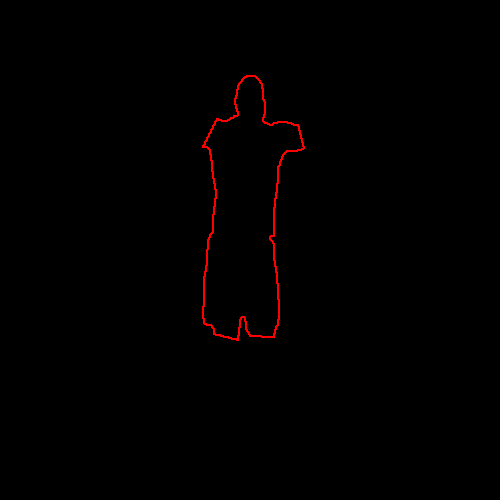

In [32]:
# Cut shoulder and waist from body
# This cell generate coutour for all the parts
# #0: head
# #1: chest
# #2: left shoulder
# #3: left elbow
# #4: left hand
# #5: right shoulder
# #6: right elbow
# #7: right hand
# #8: left waist
# #9: left knee
# #10: left foot
# #11: right waist
# #12: right knee
# #13: right foot
#POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]

workImage = np.zeros((inHeight, inWidth, 3), dtype = np.uint8)
inputImage = cv2.imread("./drive/MyDrive/PoseProject/lbj.png")
inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))

#Left arm
pointLeftShoulder, pointLeftElbow = inputPoseLines[3]
solutionLeftShoulder = findLeftAndRight(inputContourPointsRefine, pointLeftShoulder, pointLeftShoulder, pointLeftElbow)

inputLeftShoulderStart = solutionLeftShoulder[0][0]
inputLeftShoulderEnd = solutionLeftShoulder[1][0]

inputLeftShoulderCutContour = getInterPolatePoints(inputContourPointsRefine[inputLeftShoulderStart], inputContourPointsRefine[inputLeftShoulderEnd])

inputLeftArmContour = []
if inputLeftShoulderEnd - inputLeftShoulderStart < len(inputContourPointsRefine) / 2:
  inputLeftArmContour = inputLeftShoulderCutContour + inputContourPointsRefine[inputLeftShoulderStart:inputLeftShoulderEnd]
else:
  inputLeftArmContour = inputLeftShoulderCutContour + inputContourPointsRefine[inputLeftShoulderEnd:] + inputContourPointsRefine[:inputLeftShoulderStart]

#Right arm
pointRightShoulder, pointRightElbow = inputPoseLines[5]
solutionRightShoulder = findLeftAndRight(inputContourPointsRefine, pointRightShoulder, pointRightShoulder, pointRightElbow)

inputRightShoulderStart = solutionRightShoulder[0][0]
inputRightShoulderEnd = solutionRightShoulder[1][0]

inputRightShoulderCutContour = getInterPolatePoints(inputContourPointsRefine[inputRightShoulderStart], inputContourPointsRefine[inputRightShoulderEnd])

inputRightArmContour = []
if inputRightShoulderEnd - inputRightShoulderStart < len(inputContourPointsRefine) / 2:
  inputRightArmContour = inputRightShoulderCutContour + inputContourPointsRefine[inputRightShoulderStart:inputRightShoulderEnd]
else:
  inputRightArmContour = inputRightShoulderCutContour + inputContourPointsRefine[inputRightShoulderEnd:] + inputContourPointsRefine[:inputRightShoulderStart]

#Left leg
pointLeftWaist, pointLeftKnee = inputPoseLines[8]
solutionLeftLeg = findLeftAndRight(inputContourPointsRefine, pointLeftWaist, pointLeftWaist, pointLeftKnee)

inputLeftLegStart = solutionLeftLeg[0][0]
inputLeftLegEnd = solutionLeftLeg[1][0]

inputLeftLegCutContour = getInterPolatePoints(inputContourPointsRefine[inputLeftLegStart], inputContourPointsRefine[inputLeftLegEnd])

inputLeftLegContour = []
if inputLeftLegEnd - inputLeftLegStart < len(inputContourPointsRefine) / 2:
  inputLeftLegContour = inputLeftLegCutContour + inputContourPointsRefine[inputLeftLegStart:inputLeftLegEnd]
else:
  inputLeftLegContour = inputLeftLegCutContour + inputContourPointsRefine[inputLeftLegEnd:] + inputContourPointsRefine[:inputLeftLegStart]

#Right Leg
pointRightWaist, pointRightKnee = inputPoseLines[11]
solutionRightLeg = findLeftAndRight(inputContourPointsRefine, pointRightWaist, pointRightWaist, pointRightKnee)

inputRightLegStart = solutionRightLeg[0][0]
inputRightLegEnd = solutionRightLeg[1][0]

inputRightLegCutContour = getInterPolatePoints(inputContourPointsRefine[inputRightLegStart], inputContourPointsRefine[inputRightLegEnd])

inputRightLegContour = []
if inputRightLegEnd - inputRightLegStart < len(inputContourPointsRefine) / 2:
  inputRightLegContour = inputRightLegCutContour + inputContourPointsRefine[inputRightLegStart:inputRightLegEnd]
else:
  inputRightLegContour = inputRightLegCutContour + inputContourPointsRefine[inputRightLegEnd:] + inputContourPointsRefine[:inputRightLegStart]

trimmedBodyContour = []
def inInterval(target, start, end, len):
  if end - start < len / 2:
    return target > start and target < end
  else:
    return target > end or target < start

len1 = len(inputContourPointsRefine)
hasAddLeftShoulder = False
hasAddRightShoulder = False
hasAddLeftLeg = False
hasAddRightLeg = False

for i in range(len1):
  if inInterval(i, inputLeftShoulderStart, inputLeftShoulderEnd, len1): 
    if not hasAddLeftShoulder:
      trimmedBodyContour.extend(inputLeftShoulderCutContour)
      hasAddLeftShoulder = True
  elif inInterval(i, inputRightShoulderStart, inputRightShoulderEnd, len1):
    if not hasAddRightShoulder:
      trimmedBodyContour.extend(inputRightShoulderCutContour)
      hasAddRightShoulder = True
  elif inInterval(i, inputLeftLegStart, inputLeftLegEnd, len1):
    if not hasAddLeftLeg:
      trimmedBodyContour.extend(inputLeftLegCutContour)
      hasAddLeftLeg = True
  elif inInterval(i, inputRightLegStart, inputRightLegEnd, len1):
    if not hasAddRightLeg:
      trimmedBodyContour.extend(inputRightLegCutContour)
      hasAddRightLeg = True
  else:
    trimmedBodyContour.append(inputContourPointsRefine[i])

for point in trimmedBodyContour:
  ww, hh = point
  workImage[hh, ww, :] = (0, 0, 255)
  workImage[hh+1, ww, :] = (0, 0, 255)
  workImage[hh, ww+1, :] = (0, 0, 255)
  workImage[hh+1, ww+1, :] = (0, 0, 255)
cv2_imshow(workImage)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in arccos


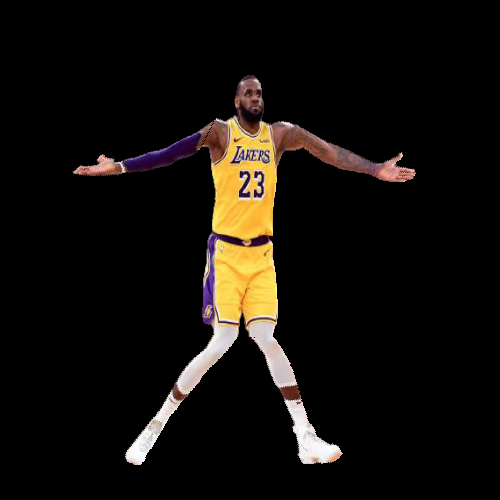

In [47]:
#do meshing and rotate
workImage = np.zeros((inHeight, inWidth, 3), dtype = np.uint8)

def find45degree(contourPoints, targetPoint, startPoint, endPoint):
  w, h = targetPoint
  wStart, hStart = startPoint
  wEnd, hEnd = endPoint

  left = -1
  right = inWidth
  startIndex = -1
  endIndex = -1

  solutions = []

  for i in range(len(contourPoints)):
    point = contourPoints[i]
    wPoint, hPoint = point

    length1 = math.sqrt((hEnd - hStart) ** 2 + (wEnd - wStart) ** 2)
    length2 = math.sqrt((hPoint - h) ** 2 + (wPoint - w) ** 2)
    if length2 == 0:
      continue
    dotProduct = (hEnd - hStart) * (hPoint - h) + (wEnd - wStart) * (wPoint - w)
    angle = np.arccos(dotProduct / length1 / length2)
    if abs(angle - math.pi / 3) < math.pi / 20:
      if startIndex == -1:
        startIndex = i
      else:
        endIndex = i
    else:
      if startIndex != -1 and endIndex != -1:
        solutions.append((startIndex, endIndex))
        startIndex = -1
        endIndex = -1

  #print(solutions)
  solutionRefine = solutions[0][1]
  ww, hh = contourPoints[solutionRefine]
  distMin = (ww - w) ** 2 + (hh - h) ** 2
  for solution in solutions:
    w3, h3 = contourPoints[solution[1]]
    distTemp = (w3 - w) ** 2 + (h3 - h) ** 2
    if distTemp < distMin:
      solutionRefine = solution[1]

  return solutionRefine

def drawContour(contour):
  hMin = inHeight
  hMax = -1
  for point in contour:
    w, h = point
    if h < hMin:
      hMin = h
    if h > hMax:
      hMax = h

  #print("h: %d, %d" % (hMin, hMax))    
  for h in range(hMin, hMax):
    wMin = inWidth
    wMax = -1
    for point in contour:
      w, h2 = point
      if h2 == h:
        if w < wMin:
          wMin = w
        if w > wMax:
          wMax = w
    for w in range(wMin, wMax):
      workImage[h, w] = inputImageResize[h, w]
  #cv2_imshow(workImage)


def drawContourWithRotation(contour, M, MInv, w0, h0):
  hMin = inHeight
  hMax = -1

  contourRotate = []
  for point in contour:
    w, h = point
    wRotate = int((w - w0) * M[0][0] + (h - h0) * M[0][1] + w0)
    hRotate = int((w - w0) * M[1][0] + (h - h0) * M[1][1] + h0)
    contourRotate.append((wRotate, hRotate))
    if hRotate < hMin:
      hMin = hRotate
    if hRotate > hMax:
      hMax = hRotate

  contourRotateRefine = []
  for i in range(0, len(contourRotate) - 1):
    for point in getInterPolatePoints(contourRotate[i], contourRotate[i+1]):
      contourRotateRefine.append(point)

  #print(contourRotateRefine)
  #print("h: %d, %d" % (hMin, hMax))    
  for h in range(hMin, hMax):
    wMin = inWidth
    wMax = -1
    for point in contourRotateRefine:
      w, h2 = point
      if h2 == h:
        if w < wMin:
          wMin = w
        if w > wMax:
          wMax = w
    for w in range(wMin, wMax):
      w2 = int((w - w0) * MInv[0][0] + (h - h0) * MInv[0][1] + w0)
      h2 = int((w - w0) * MInv[1][0] + (h - h0) * MInv[1][1] + h0)
      workImage[h, w] = inputImageResize[h2, w2]


#rotate left arm
inputLeftShoulderCutContour = getInterPolatePoints(inputContourPointsRefine[inputLeftShoulderStart], inputContourPointsRefine[inputLeftShoulderEnd])
leftArmAngle = math.pi / 3

solution = find45degree(inputLeftArmContour, inputLeftArmContour[0], inputLeftArmContour[0], inputLeftArmContour[len(inputLeftShoulderCutContour) - 1])

pointA = inputLeftArmContour[solution]
triangle = []
if abs(solution - len(inputLeftShoulderCutContour)) > len(inputLeftArmContour) / 2 :
  triangle.extend(inputLeftShoulderCutContour)
  triangle.extend(inputLeftArmContour[solution:])
  triangle.extend(inputLeftArmContour[:len(inputLeftShoulderCutContour) - 1])
else:
  triangle.extend(inputLeftArmContour[:solution])

newLine = getInterPolatePoints(pointA, inputLeftShoulderCutContour[0])
triangle.extend(newLine)

w1, h1 = inputLeftShoulderCutContour[0]
w2, h2 = inputLeftShoulderCutContour[-1]
w3, h3 = pointA
inputPair = np.array( [[0, 0], [w2 - w1, h2 - h1], [w3 - w1, h3 - h1]] ).astype(np.float32)
refPair = np.array( [[0, 0], [w2 - w1, h2 - h1], [math.cos(leftArmAngle) * (w3 - w1) + math.sin(leftArmAngle) * (h3 - h1), -math.sin(leftArmAngle) * (w3 - w1) + math.cos(leftArmAngle) * (h3 - h1)]] ).astype(np.float32)

M = cv2.getAffineTransform(inputPair, refPair)
MInv = cv2.getAffineTransform(refPair, inputPair)
drawContourWithRotation(triangle, M, MInv, w1, h1)

armContourCut45 = []
armContourCut45.extend(inputLeftArmContour[solution:])
armContourCut45.extend(newLine)
inputPair = np.array( [[0, 0], [0, -1], [-1, 0]] ).astype(np.float32)
refPair = np.array( [[0, 0], [-math.sin(leftArmAngle), -math.cos(leftArmAngle)], [-math.cos(leftArmAngle), math.sin(leftArmAngle)]] ).astype(np.float32)

M = cv2.getAffineTransform(inputPair, refPair)
MInv = cv2.getAffineTransform(refPair, inputPair)
drawContourWithRotation(armContourCut45, M, MInv, w1, h1)

#rotate right arm
inputRightShoulderCutContour = getInterPolatePoints(inputContourPointsRefine[inputRightShoulderStart], inputContourPointsRefine[inputRightShoulderEnd])
rightArmAngle = -math.pi / 3

solution = find45degree(inputRightArmContour, inputRightArmContour[0], inputRightArmContour[0], inputRightArmContour[len(inputRightShoulderCutContour) - 1])

pointA = inputRightArmContour[solution]
triangle = []

if abs(solution - len(inputRightShoulderCutContour)) > len(inputRightArmContour) / 2 :
  triangle.extend(inputRightShoulderCutContour)
  triangle.extend(inputRightArmContour[solution:])
  triangle.extend(inputRightArmContour[:len(inputRightShoulderCutContour) - 1])
else:
  triangle.extend(inputRightArmContour[:solution])

newLine = getInterPolatePoints(pointA, inputRightShoulderCutContour[0])
triangle.extend(newLine)

w1, h1 = inputRightShoulderCutContour[0]
w2, h2 = inputRightShoulderCutContour[-1]
w3, h3 = pointA
inputPair = np.array( [[0, 0], [w2 - w1, h2 - h1], [w3 - w1, h3 - h1]] ).astype(np.float32)
refPair = np.array( [[0, 0], [w2 - w1, h2 - h1], [math.cos(rightArmAngle) * (w3 - w1) + math.sin(rightArmAngle) * (h3 - h1), -math.sin(rightArmAngle) * (w3 - w1) + math.cos(rightArmAngle) * (h3 - h1)]] ).astype(np.float32)

M = cv2.getAffineTransform(inputPair, refPair)
MInv = cv2.getAffineTransform(refPair, inputPair)
drawContourWithRotation(triangle, M, MInv, w1, h1)

armContourCut45 = []
armContourCut45.extend(inputRightArmContour[len(inputRightShoulderCutContour) : solution])
armContourCut45.extend(newLine)
inputPair = np.array( [[0, 0], [0, -1], [-1, 0]] ).astype(np.float32)
refPair = np.array( [[0, 0], [-math.sin(rightArmAngle), -math.cos(rightArmAngle)], [-math.cos(rightArmAngle), math.sin(rightArmAngle)]] ).astype(np.float32)

M = cv2.getAffineTransform(inputPair, refPair)
MInv = cv2.getAffineTransform(refPair, inputPair)
drawContourWithRotation(armContourCut45, M, MInv, w1, h1)

##############
#rotate left leg
inputLeftLegCutContour = getInterPolatePoints(inputContourPointsRefine[inputLeftLegStart], inputContourPointsRefine[inputLeftLegEnd])
leftLegAngle = -math.pi / 6

solution = find45degree(inputLeftLegContour, inputLeftLegContour[0], inputLeftLegContour[0], inputLeftLegContour[len(inputLeftLegCutContour) - 1])
pointA = inputLeftLegContour[solution]
triangle = []

if abs(solution - len(inputLeftLegCutContour)) > len(inputLeftLegContour) / 2 :
  triangle.extend(inputLeftLegCutContour)
  triangle.extend(inputLeftLegContour[solution:])
  triangle.extend(inputLeftLegContour[:len(inputLeftLegCutContour) - 1])
else:
  triangle.extend(inputLeftLegContour[:solution])

newLine = getInterPolatePoints(pointA, inputLeftLegCutContour[0])
triangle.extend(newLine)

w1, h1 = inputLeftLegCutContour[0]
w2, h2 = inputLeftLegCutContour[-1]
w3, h3 = pointA
inputPair = np.array( [[0, 0], [w2 - w1, h2 - h1], [w3 - w1, h3 - h1]] ).astype(np.float32)
refPair = np.array( [[0, 0], [w2 - w1, h2 - h1], [math.cos(leftLegAngle) * (w3 - w1) + math.sin(leftLegAngle) * (h3 - h1), -math.sin(leftLegAngle) * (w3 - w1) + math.cos(leftLegAngle) * (h3 - h1)]] ).astype(np.float32)

M = cv2.getAffineTransform(inputPair, refPair)
MInv = cv2.getAffineTransform(refPair, inputPair)
drawContourWithRotation(triangle, M, MInv, w1, h1)

legContourCut45 = []
legContourCut45.extend(inputLeftLegContour[len(inputLeftLegCutContour) : solution])
legContourCut45.extend(newLine)
inputPair = np.array( [[0, 0], [0, -1], [-1, 0]] ).astype(np.float32)
refPair = np.array( [[0, 0], [-math.sin(leftLegAngle), -math.cos(leftLegAngle)], [-math.cos(leftLegAngle), math.sin(leftLegAngle)]] ).astype(np.float32)

M = cv2.getAffineTransform(inputPair, refPair)
MInv = cv2.getAffineTransform(refPair, inputPair)
drawContourWithRotation(legContourCut45, M, MInv, w1, h1)

##############
#rotate right leg
inputRightLegCutContour = getInterPolatePoints(inputContourPointsRefine[inputRightLegStart], inputContourPointsRefine[inputRightLegEnd])
rightLegAngle = math.pi / 6

solution = find45degree(inputRightLegContour, inputRightLegContour[0], inputRightLegContour[0], inputRightLegContour[len(inputRightLegCutContour) - 1])

pointA = inputRightLegContour[solution]
triangle = []

if abs(solution - len(inputRightLegCutContour)) > len(inputRightLegContour) / 2 :
  triangle.extend(inputRightLegCutContour)
  triangle.extend(inputRightLegContour[solution:])
  triangle.extend(inputRightLegContour[:len(inputRightLegCutContour) - 1])
else:
  triangle.extend(inputRightLegCutContour[:solution])

newLine = getInterPolatePoints(pointA, inputRightLegCutContour[0])
triangle.extend(newLine)

w1, h1 = inputRightLegCutContour[0]
w2, h2 = inputRightLegCutContour[-1]
w3, h3 = pointA
inputPair = np.array( [[0, 0], [w2 - w1, h2 - h1], [w3 - w1, h3 - h1]] ).astype(np.float32)
refPair = np.array( [[0, 0], [w2 - w1, h2 - h1], [math.cos(rightLegAngle) * (w3 - w1) + math.sin(rightLegAngle) * (h3 - h1), -math.sin(rightLegAngle) * (w3 - w1) + math.cos(rightLegAngle) * (h3 - h1)]] ).astype(np.float32)

M = cv2.getAffineTransform(inputPair, refPair)
MInv = cv2.getAffineTransform(refPair, inputPair)
drawContourWithRotation(triangle, M, MInv, w1, h1)

legContourCut45 = []
legContourCut45.extend(inputRightLegContour[len(inputRightLegCutContour) : solution])
legContourCut45.extend(newLine)
inputPair = np.array( [[0, 0], [0, -1], [-1, 0]] ).astype(np.float32)
refPair = np.array( [[0, 0], [-math.sin(rightLegAngle), -math.cos(rightLegAngle)], [-math.cos(rightLegAngle), math.sin(rightLegAngle)]] ).astype(np.float32)

M = cv2.getAffineTransform(inputPair, refPair)
MInv = cv2.getAffineTransform(refPair, inputPair)
drawContourWithRotation(legContourCut45, M, MInv, w1, h1)

#####
drawContour(trimmedBodyContour)

cv2_imshow(workImage)

